In [14]:
import sys
import torch
from data_loader_estimated import EstimatedDataset
sys.path.append("../tsy935/RubinLab_neurotranslate_eeg-master/eeg/data/")
sys.path.append("../forward_model/")
import stacklineplot
import pyedflib
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 25, 10 * 3
import h5py

In [2]:
train_files = open("../tsy935/RubinLab_neurotranslate_eeg-master/eeg/data/train_seizure_files.txt", "r").readlines()
train_files = [x.strip("\n").split(",") for x in train_files]

In [3]:
train_files[:10]

[['/mnt/data1/eegdbs/TUH/temple/tuh-sz-v1.2.0/v1.2.0/train/03_tcp_ar_a/00000883/s012_2010_09_13/00000883_s012_t003.edf',
  '0',
  '0'],
 ['/mnt/data1/eegdbs/TUH/temple/tuh-sz-v1.2.0/v1.2.0/train/03_tcp_ar_a/00007032/s007_2011_02_10/00007032_s007_t004.edf',
  '1',
  '0'],
 ['/mnt/data1/eegdbs/TUH/temple/tuh-sz-v1.2.0/v1.2.0/train/03_tcp_ar_a/00007032/s007_2011_02_10/00007032_s007_t005.edf',
  '0',
  '0'],
 ['/mnt/data1/eegdbs/TUH/temple/tuh-sz-v1.2.0/v1.2.0/train/03_tcp_ar_a/00007032/s007_2011_02_10/00007032_s007_t005.edf',
  '0',
  '1'],
 ['/mnt/data1/eegdbs/TUH/temple/tuh-sz-v1.2.0/v1.2.0/train/03_tcp_ar_a/00007032/s007_2011_02_10/00007032_s007_t005.edf',
  '0',
  '2'],
 ['/mnt/data1/eegdbs/TUH/temple/tuh-sz-v1.2.0/v1.2.0/train/03_tcp_ar_a/00007032/s007_2011_02_10/00007032_s007_t005.edf',
  '0',
  '3'],
 ['/mnt/data1/eegdbs/TUH/temple/tuh-sz-v1.2.0/v1.2.0/train/03_tcp_ar_a/00007032/s007_2011_02_10/00007032_s007_t000.edf',
  '1',
  '0'],
 ['/mnt/data1/eegdbs/TUH/temple/tuh-sz-v1.2.0/v1

In [4]:
def load_signals(f, n_samples=-1):
    n = f.signals_in_file
    if n_samples != -1 and n_samples > f.getNSamples()[0]:
        print("not enough samples", f.getNSamples()[0])
        return
    elif n_samples == -1:
        n_samples = f.getNSamples()[0]
        
    sigbufs = np.zeros((n, n_samples))
    for i in np.arange(n):
#         print(f.readSignal(i).shape)
        cur_sample = f.readSignal(i)
        if cur_sample.shape[0] < n_samples:
            continue
        sigbufs[i, :] = cur_sample[:n_samples]
    return sigbufs
    

In [5]:
# def load_signals(f):
#     n = f.signals_in_file
#     sigbufs = np.zeros((n, f.getNSamples()[0])) 
#     for i in np.arange(n): 
#         sigbufs[i, :] = f.readSignal(i) 
#     return sigbufs

In [85]:
f = pyedflib.EdfReader(train_files[0][0])

In [86]:
labels = f.getSignalLabels()
signals = load_signals(f, n_samples=1000)
print("signals shape", signals.shape)

signals shape (32, 1000)


In [87]:
signals.shape

(32, 1000)

In [88]:
np.sum(signals)

-42130.74760244258

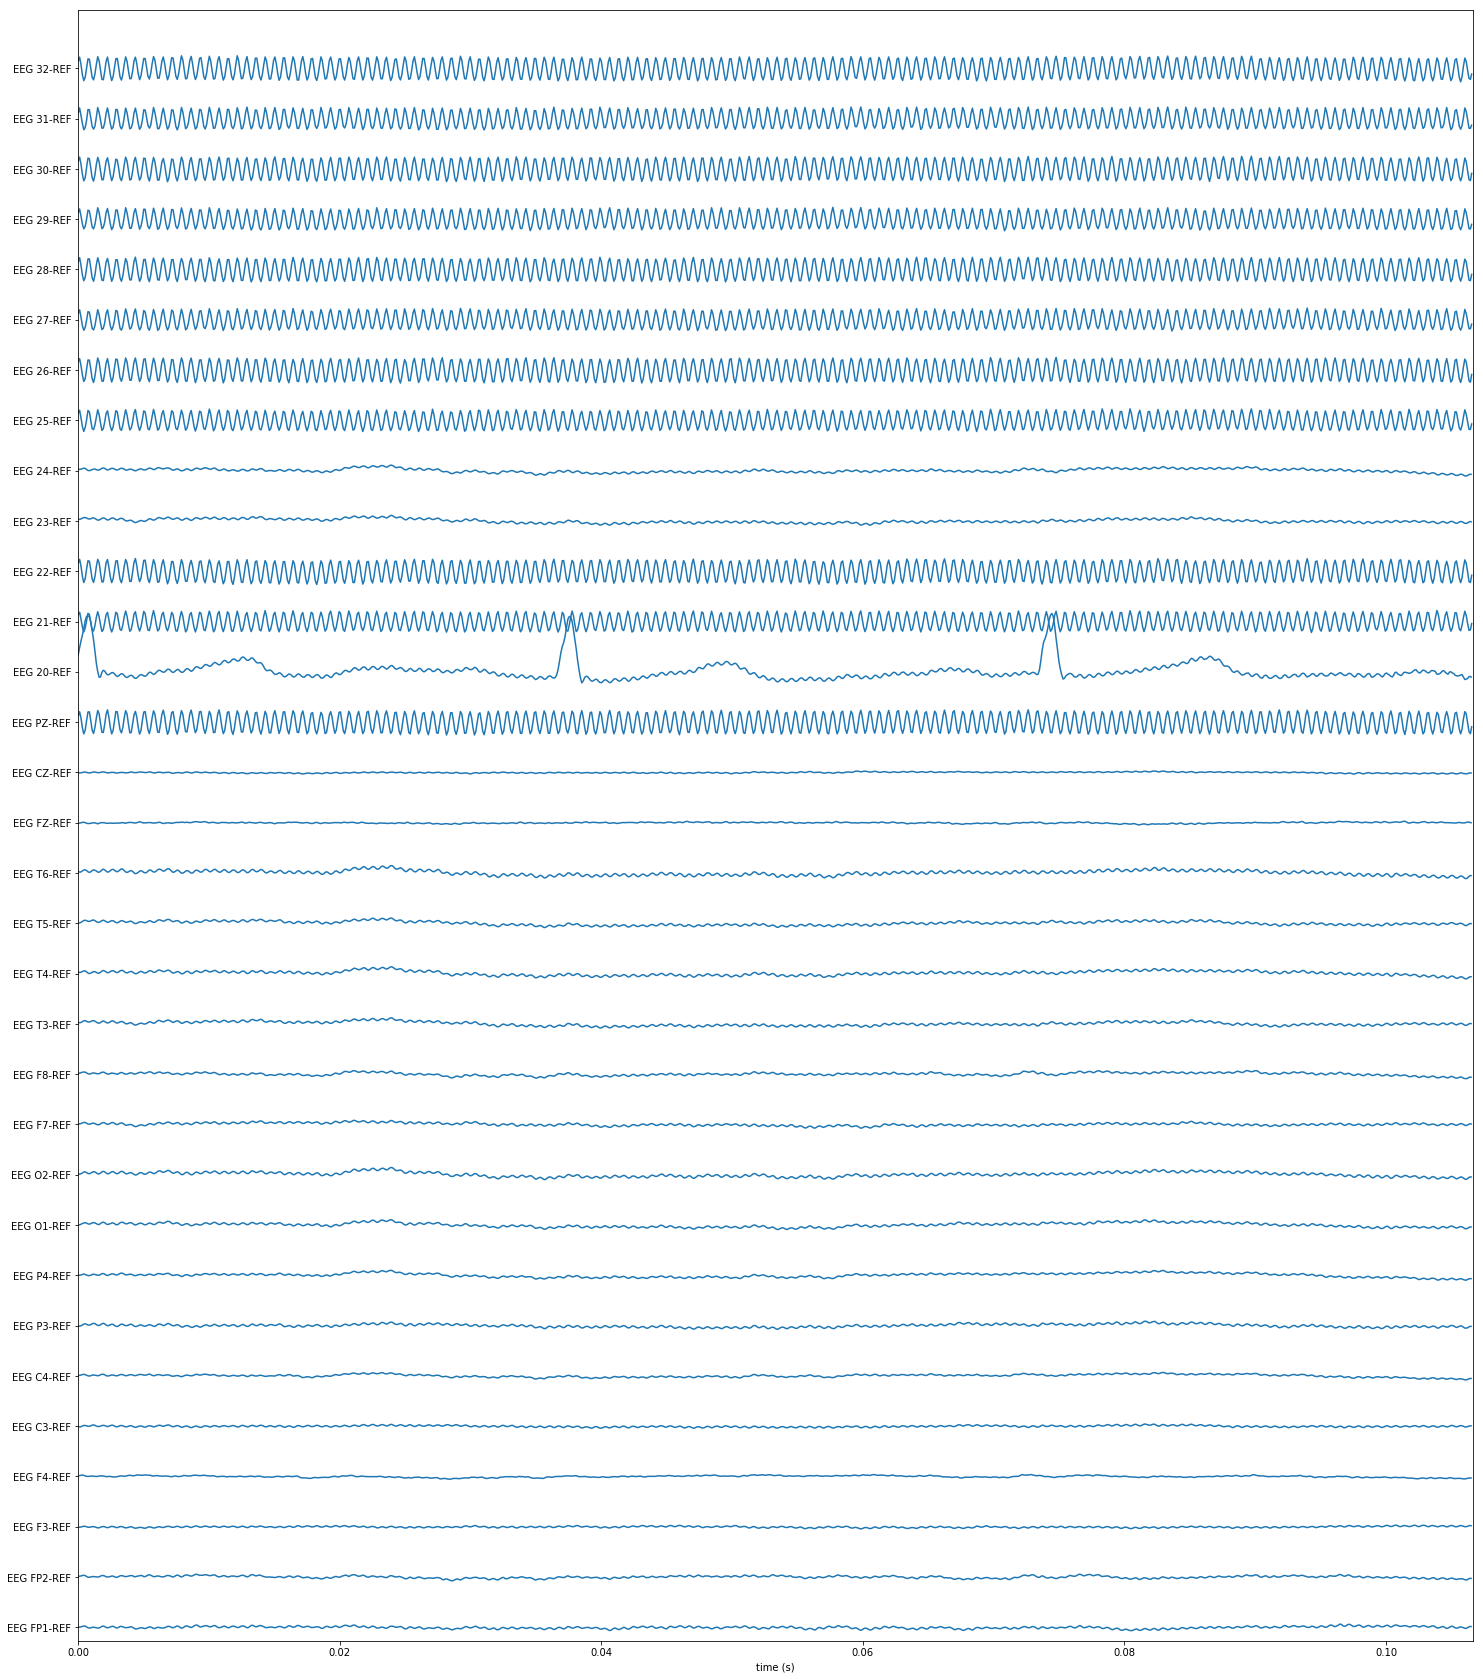

In [89]:
stacklineplot.stackplot(signals ,seconds=signals.shape[0]/300, ylabels=labels, yscale=1)

superimpose on estimated data

In [27]:
train_dataset = EstimatedDataset(8)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    shuffle=True,
    batch_size=2,
)
for a, c in train_loader:
    raw = a
    div_spec = c 

    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
Reading forward solution from /mnt/home2/dlongo/eegML/forward_model/sample_forward_model...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]


/mnt/home2/dlongo/eegML/data_loaders/forward_model_dataloader.py:60: RuntimeWarning: This filename (/mnt/home2/dlongo/eegML/forward_model/sample_forward_model) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution("/mnt/home2/dlongo/eegML/forward_model/sample_forward_model")


Projecting source estimate to sensor space...
[done]
Projecting source estimate to sensor space...
[done]
Projecting source estimate to sensor space...
[done]
Projecting source estimate to sensor space...
[done]
Projecting source estimate to sensor space...
[done]
Projecting source estimate to sensor space...
[done]
Projecting source estimate to sensor space...
[done]
Projecting source estimate to sensor space...
[done]


In [90]:
gamma = 1e2*.5

In [91]:
with_noise = raw + (torch.from_numpy(signals[:20, :1000]).type(torch.FloatTensor) * gamma)

In [92]:
i = 0
sample = raw[i]
noise_sample = signals
noisy_sample = with_noise[i]

In [93]:
print("original", torch.sum(torch.abs(sample)))
print("noise", np.sum(np.abs(signals)))
print("superimposed", torch.sum(torch.abs(noisy_sample)))

original tensor(88434752.)
noise 1052964.234066286
superimposed tensor(91178672.)


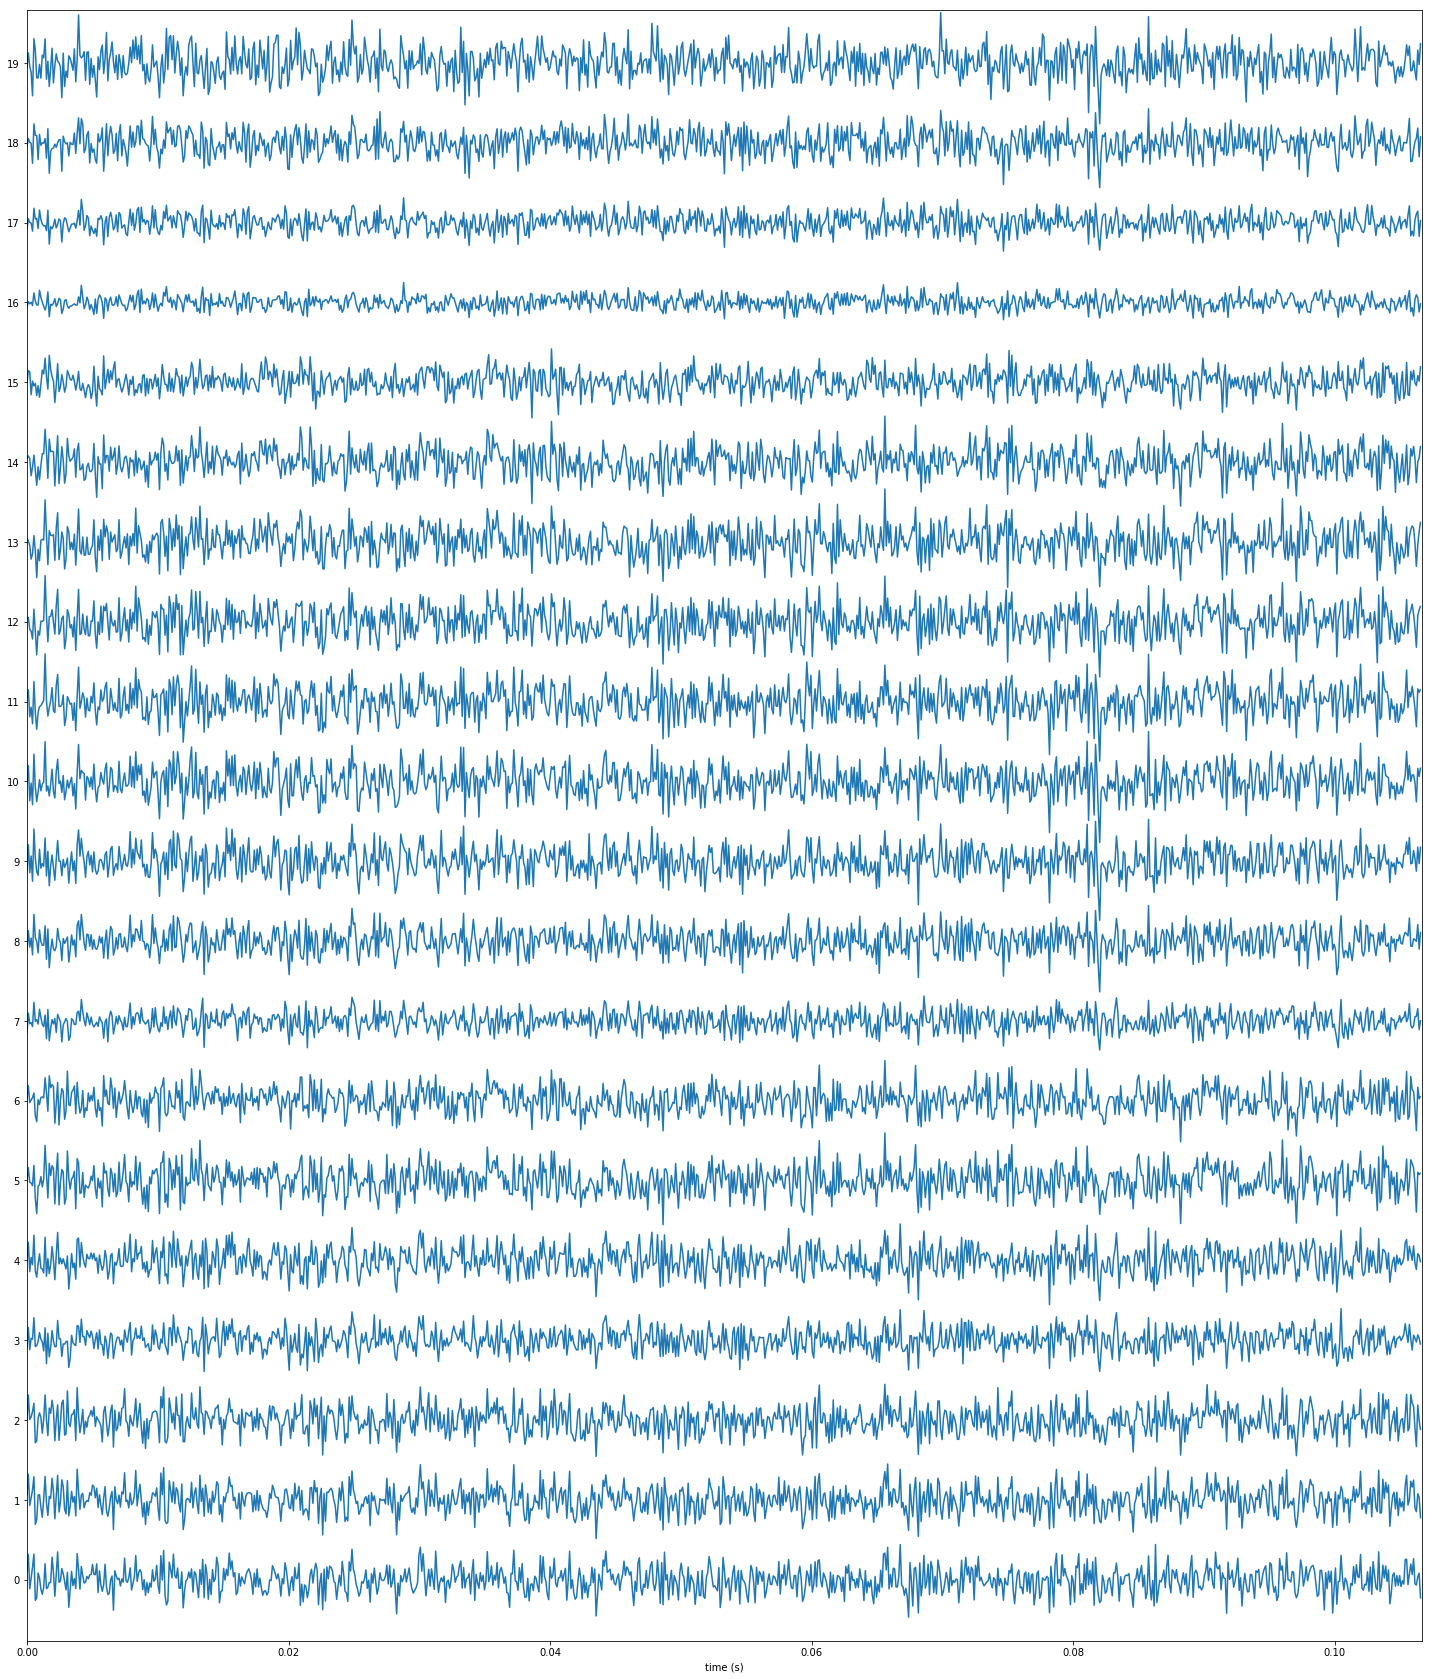

In [94]:
stacklineplot.stackplot(sample ,seconds=signals.shape[0]/300, ylabels=list(range(sample.shape[0])), yscale=1)

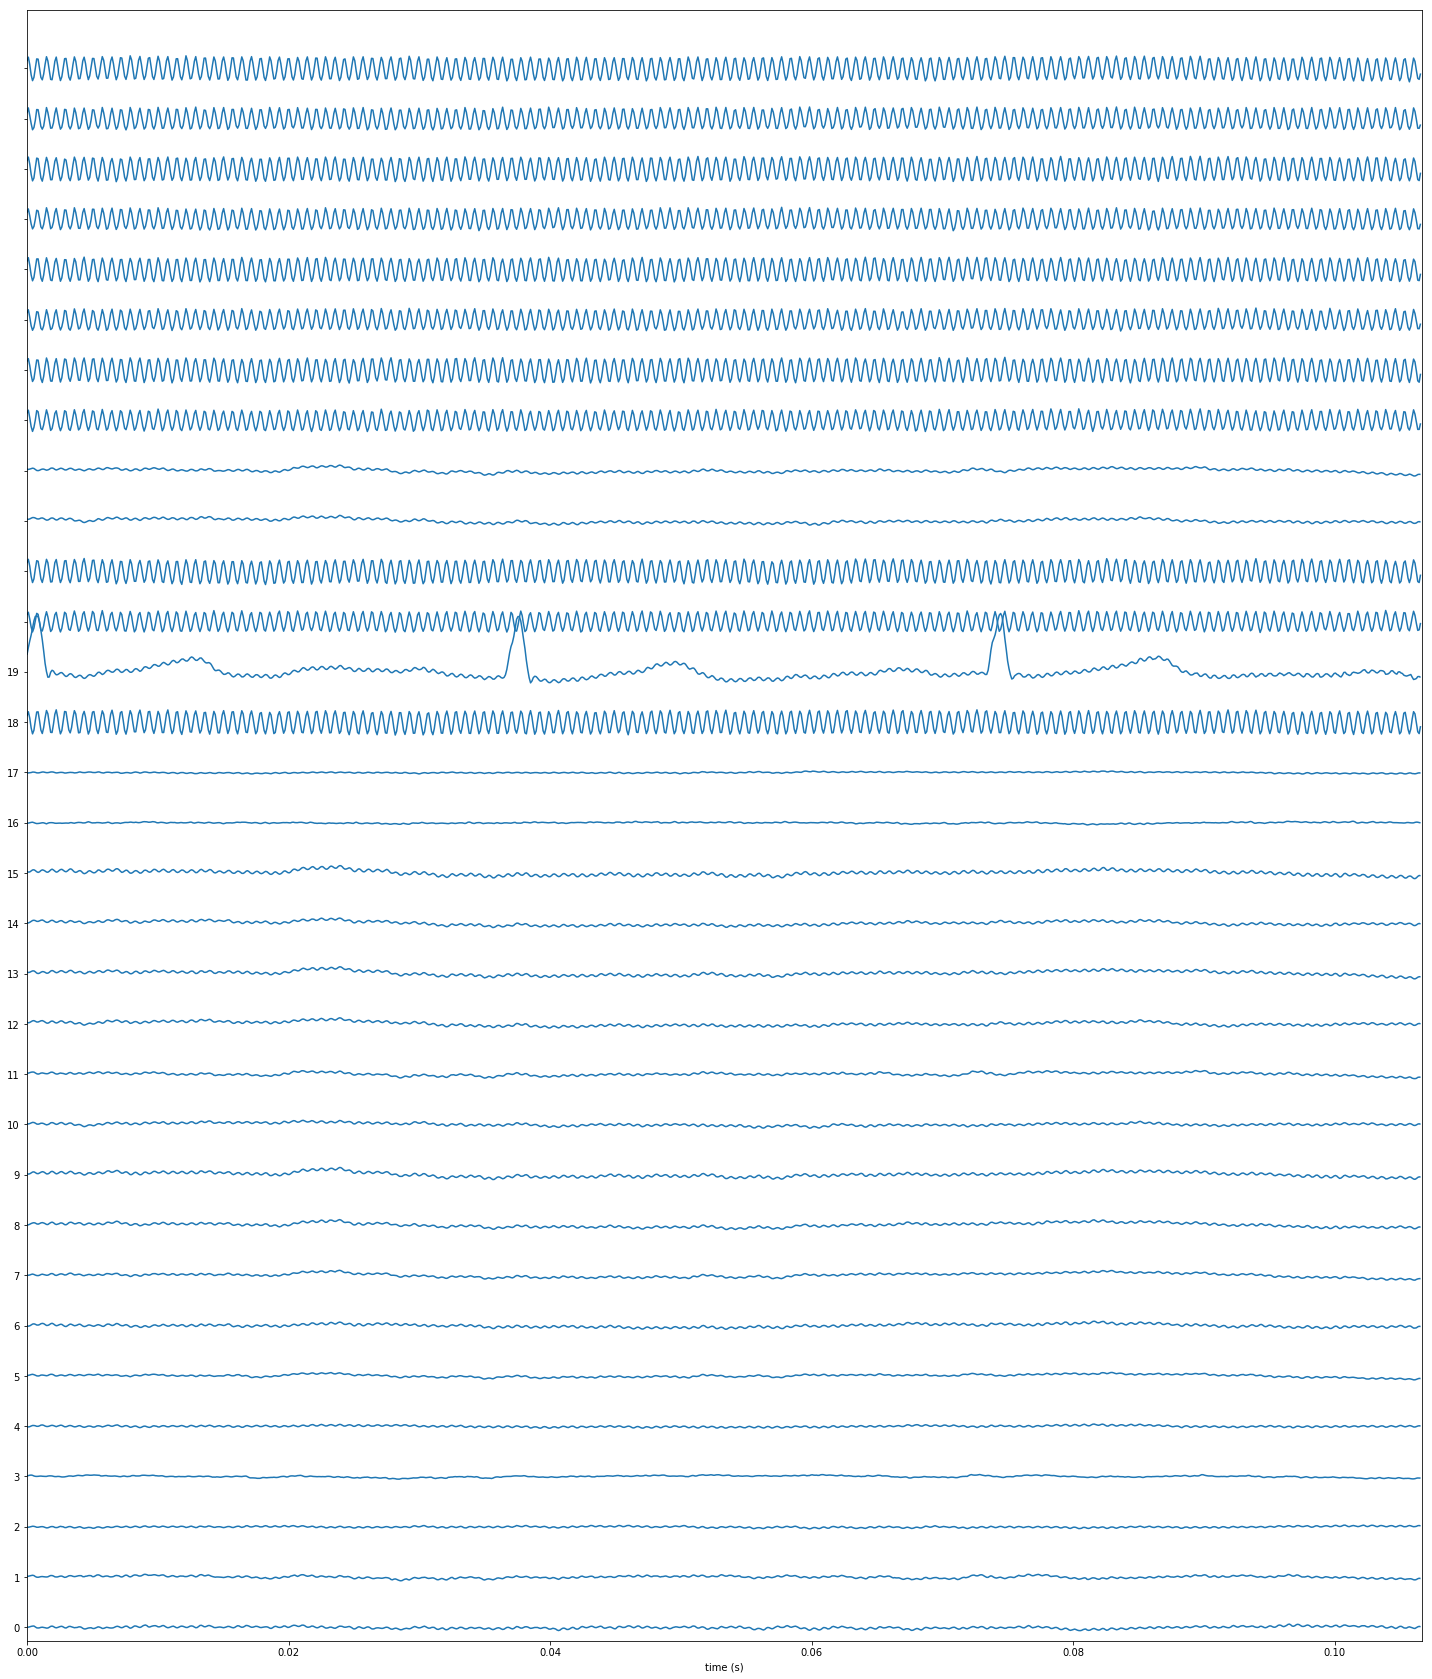

In [95]:
stacklineplot.stackplot(noise_sample ,seconds=signals.shape[0]/300, ylabels=list(range(noisy_sample.shape[0])), yscale=1)

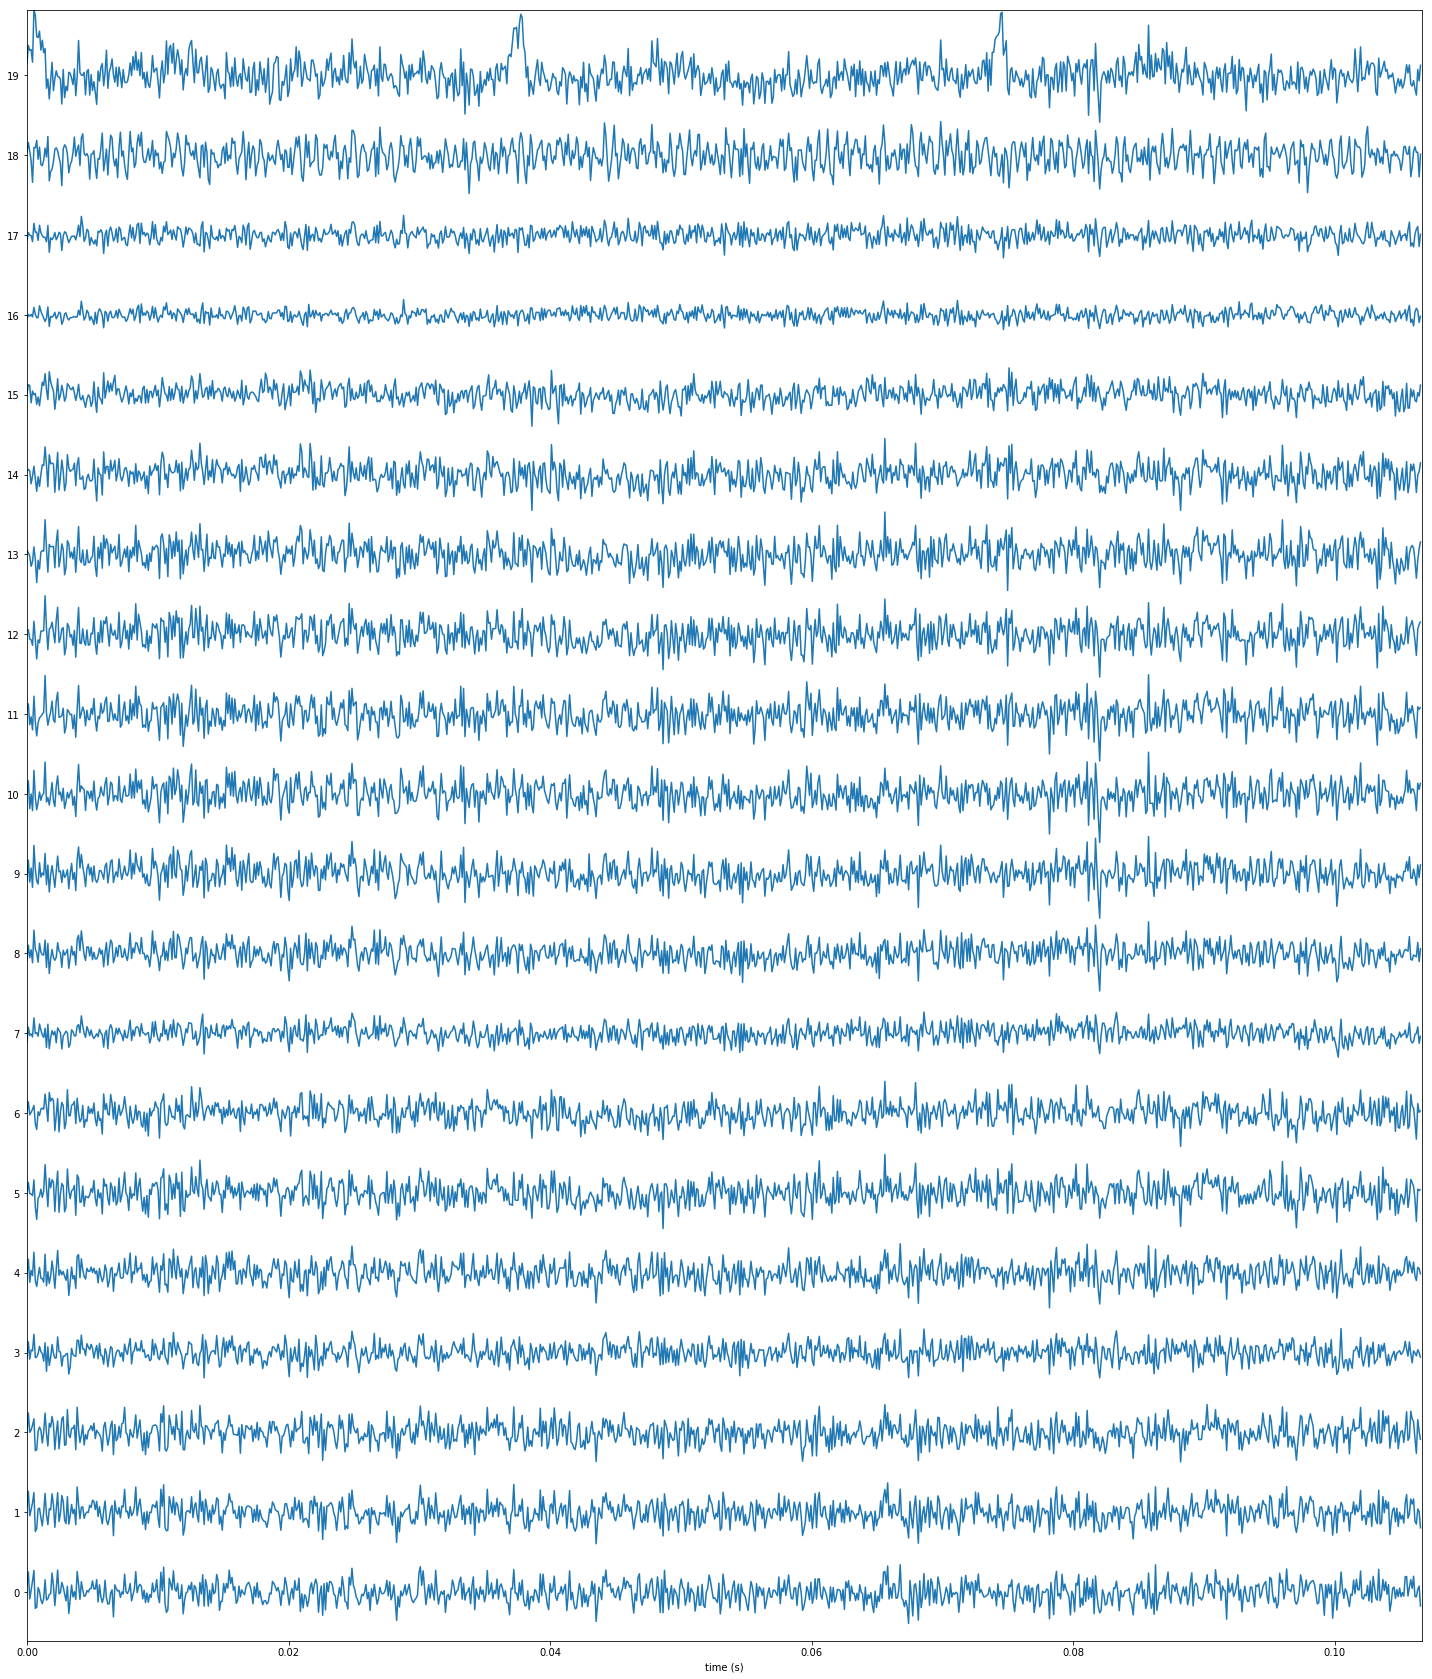

In [96]:
stacklineplot.stackplot(noisy_sample ,seconds=signals.shape[0]/300, ylabels=list(range(noisy_sample.shape[0])), yscale=1)

In [ ]:
raw_converted = compute_div_spec(raw.clone())
raw_converted = normalize(raw_converted)
raw_converted_sample = raw_converted[0].numpy()
raw_converted_sample.shape

### Save Sectors of Noise and Artifact

In [1]:
#1000 samples

In [ ]:
def add_recording()